### Projeto: Otimização de Cadeias de Suprimentos com Modelagem de Séries Temporais

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure
import math
from math import sqrt 
import sklearn as sk
from sklearn.metrics import mean_squared_error 
import statsmodels as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Imports para análise de dados
import scipy
from scipy.stats import boxcox
import warnings

In [2]:
# Carrega dataset
df = pd.read_csv('dataset.csv')

Analise Exploratoria

In [3]:
df.head()

,data,demanda_insumos_kg
0,2023-01-01,99.708762
1,2023-01-02,98.475161
2,2023-01-03,98.714361
3,2023-01-04,99.238156
4,2023-01-05,101.608597


In [4]:
df.dtypes

data                   object
demanda_insumos_kg    float64
dtype: object

In [5]:
# Converte Data como DateTime
df['data'] = pd.to_datetime(df['data'], format='mixed')
                            #format='%Y-%m')

In [6]:
df.dtypes

data                  datetime64[ns]
demanda_insumos_kg           float64
dtype: object

In [7]:
df

,data,demanda_insumos_kg
0,2023-01-01,99.708762
1,2023-01-02,98.475161
2,2023-01-03,98.714361
3,2023-01-04,99.238156
4,2023-01-05,101.608597
...,...,...
726,2024-12-27,138.491737
727,2024-12-28,137.528450
728,2024-12-29,136.367028
729,2024-12-30,135.440340


In [8]:
# Data como Index
df.index = df['data']

In [9]:
df.head()

,data,demanda_insumos_kg
data,,
2023-01-01,2023-01-01,99.708762
2023-01-02,2023-01-02,98.475161
2023-01-03,2023-01-03,98.714361
2023-01-04,2023-01-04,99.238156
2023-01-05,2023-01-05,101.608597


In [10]:
# Drop colum data
df.drop('data', axis=1, inplace=True)

In [11]:
df.head()

,demanda_insumos_kg
data,
2023-01-01,99.708762
2023-01-02,98.475161
2023-01-03,98.714361
2023-01-04,99.238156
2023-01-05,101.608597


In [12]:
df.isnull().sum()

demanda_insumos_kg    0
dtype: int64

In [13]:
df = df.dropna()

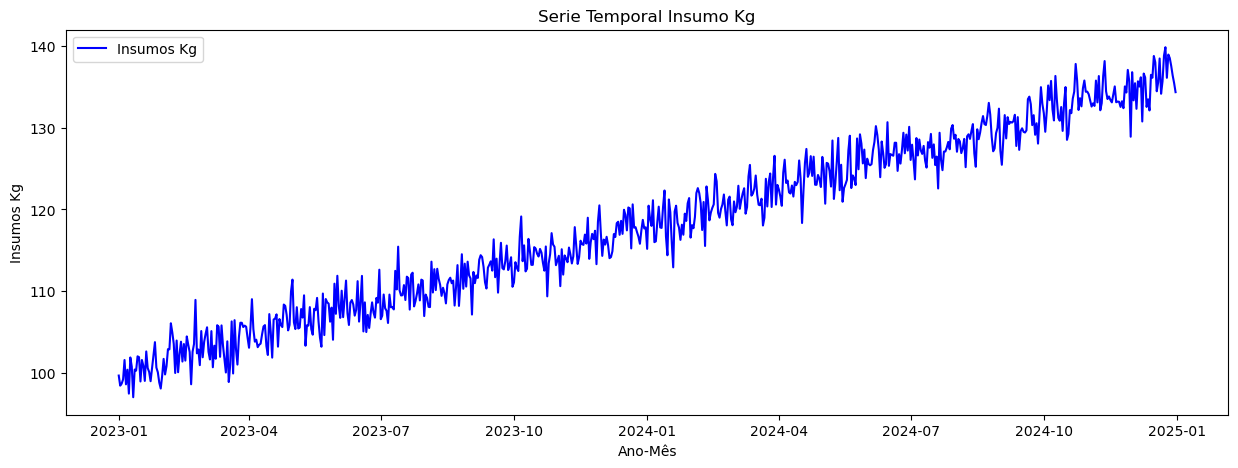

In [14]:
# Plot
figure(figsize = (15, 5))
plt.title("Serie Temporal Insumo Kg")
plt.plot(df, label = "Insumos Kg", color = 'blue')
plt.xlabel("Ano-Mês")
plt.ylabel("Insumos Kg")
plt.legend(loc = "best")
plt.show();

In [15]:
# Período completo
print('Início do Período de Tempo: {}\nFinal do Período de Tempo: {}'.format(df.index.min(), df.index.max()))

Início do Período de Tempo: 2023-01-01 00:00:00
Final do Período de Tempo: 2024-12-31 00:00:00


In [16]:
df.describe()

,demanda_insumos_kg
count,731.000000
mean,118.057784
std,10.663148
min,97.061685
25%,108.936372
50%,117.820828
75%,127.200108
max,139.818436


### Grafico de Densidade

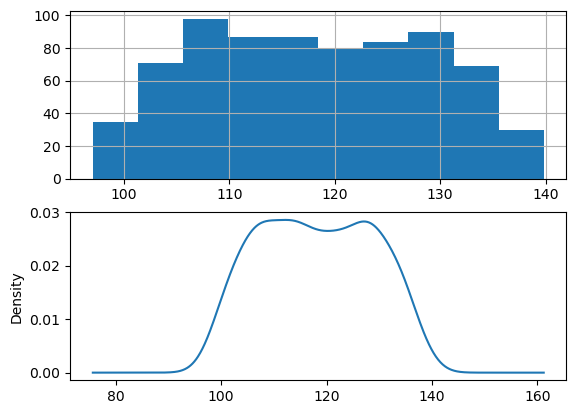

In [17]:
# Gráfico de Densidade

# Plot
plt.figure(1)

# Subplot 1
plt.subplot(211)
df.demanda_insumos_kg.hist()

# Subplot 2
plt.subplot(212)
df.demanda_insumos_kg.plot(kind = 'kde')
plt.show()

Análise Histograma e Densidade:
    
- A distribuição é gaussiana (distribuição normal).
- O que indica que não será necessário transformação pré-processamento da modelagem.

### Gráfico Box Plot Anual

Text(0, 0.5, '\nDemanda Insumos Kg')

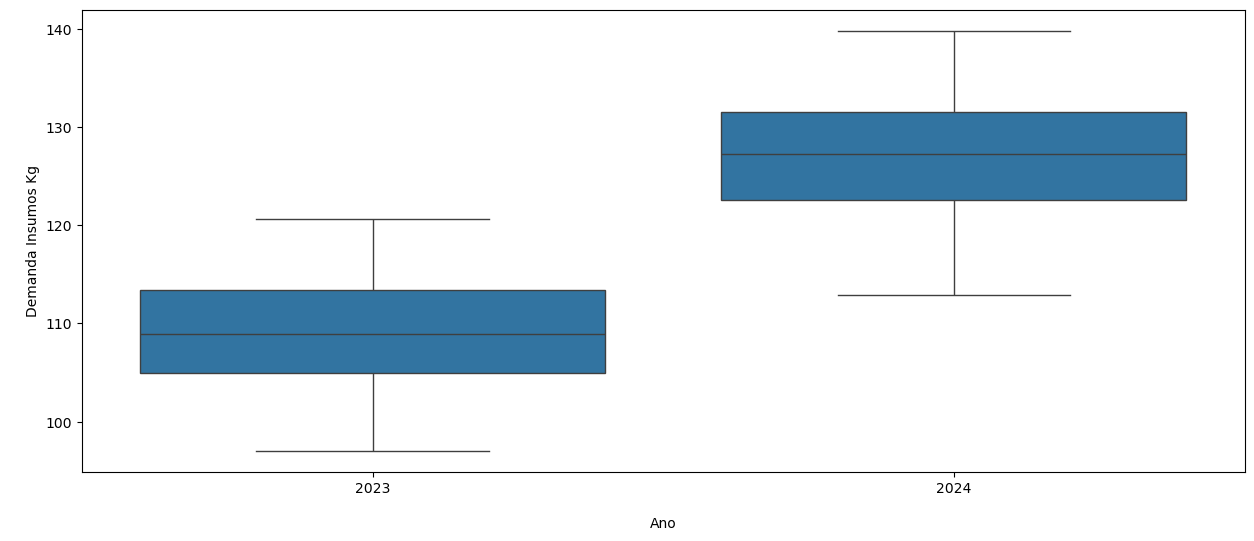

In [18]:
# Grafico Box Plot Anual

fig, ax = plt.subplots(figsize = (15,6))

# Define as variáveis
indice_ano = df.demanda_insumos_kg.index.year
valor = df.demanda_insumos_kg

# Cria um box plot para cada ano usando o Seaborn
# Observe que estamos extraindo o ano (year) do índice da série
sns.boxplot(x = indice_ano, y = valor, ax = ax, data = df)

plt.xlabel("\nAno")
plt.ylabel("\nDemanda Insumos Kg")

Análise do Box Plot

- Observado o aumento da mediana ao longo dos anos confirma uma tendência ascendente, e existe padrão da dispersão da mediana, e também mantem-se o tamanho das caixas.

### Decomposição da Série Temporal

In [19]:
# Decomposição
decompose_mult = seasonal_decompose(df, model='multiplicative', extrapolate_trend= 'freq')
                                    #period=7)

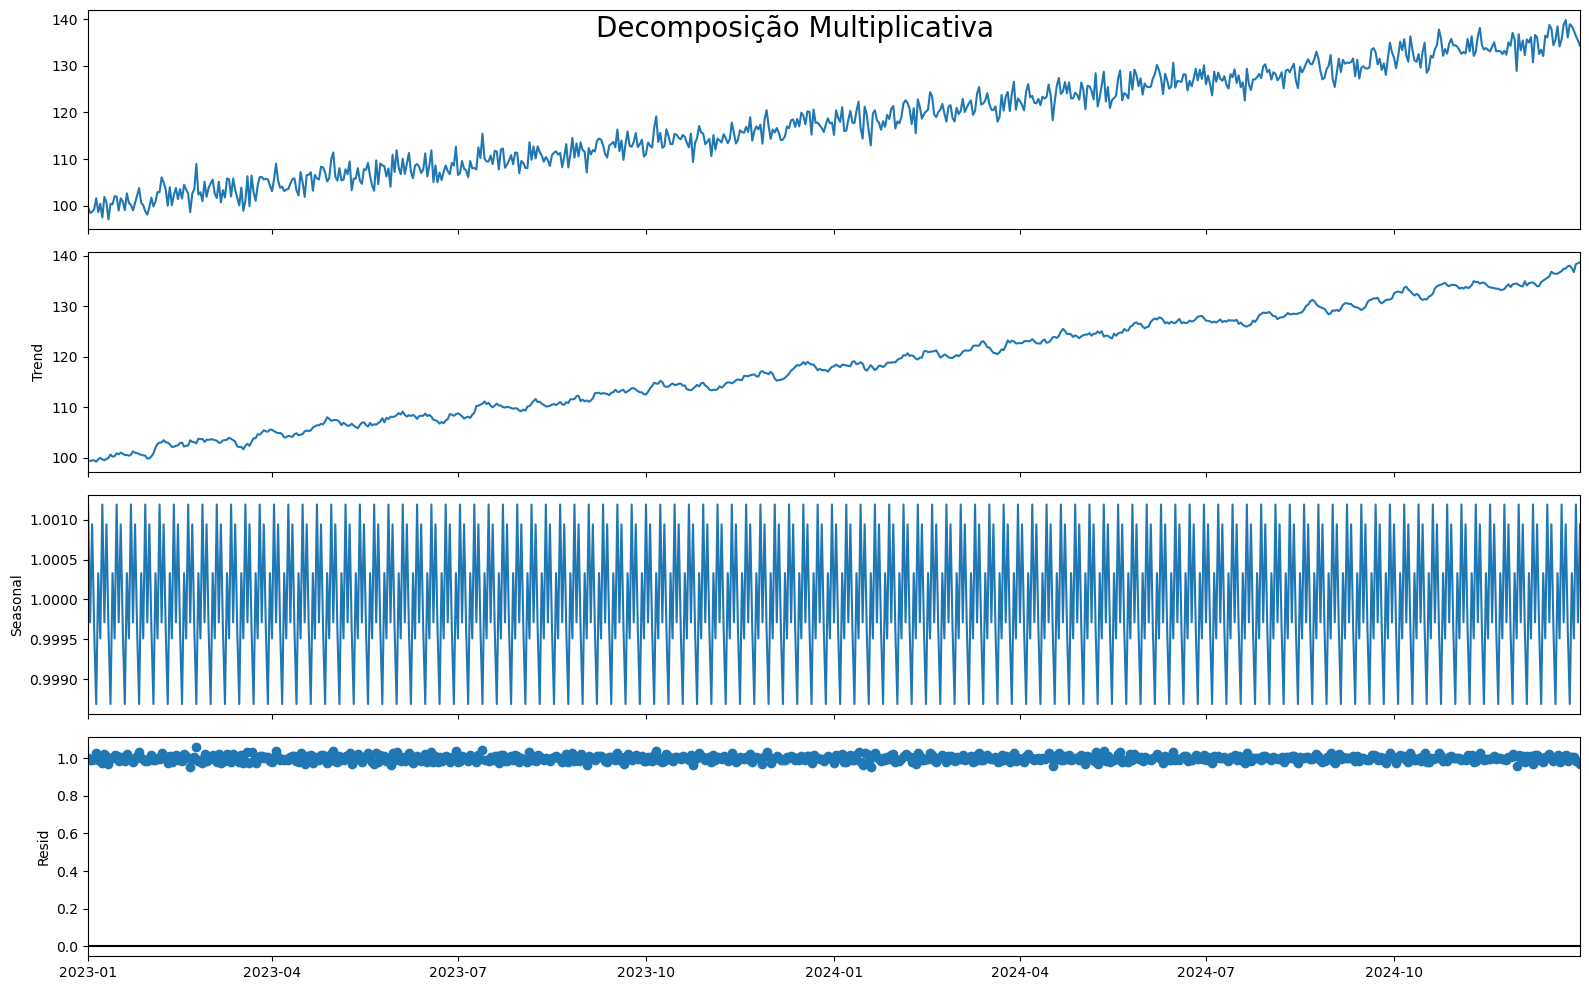

In [20]:
# Plot
plt.rcParams.update({'figure.figsize': (16,10)})
decompose_mult.plot().suptitle('Decomposição Multiplicativa', fontsize = 20)
plt.show()

In [21]:
# Decomposição
decompose_adt = seasonal_decompose(df, model='add', extrapolate_trend= 'freq')
                                   #period=7)

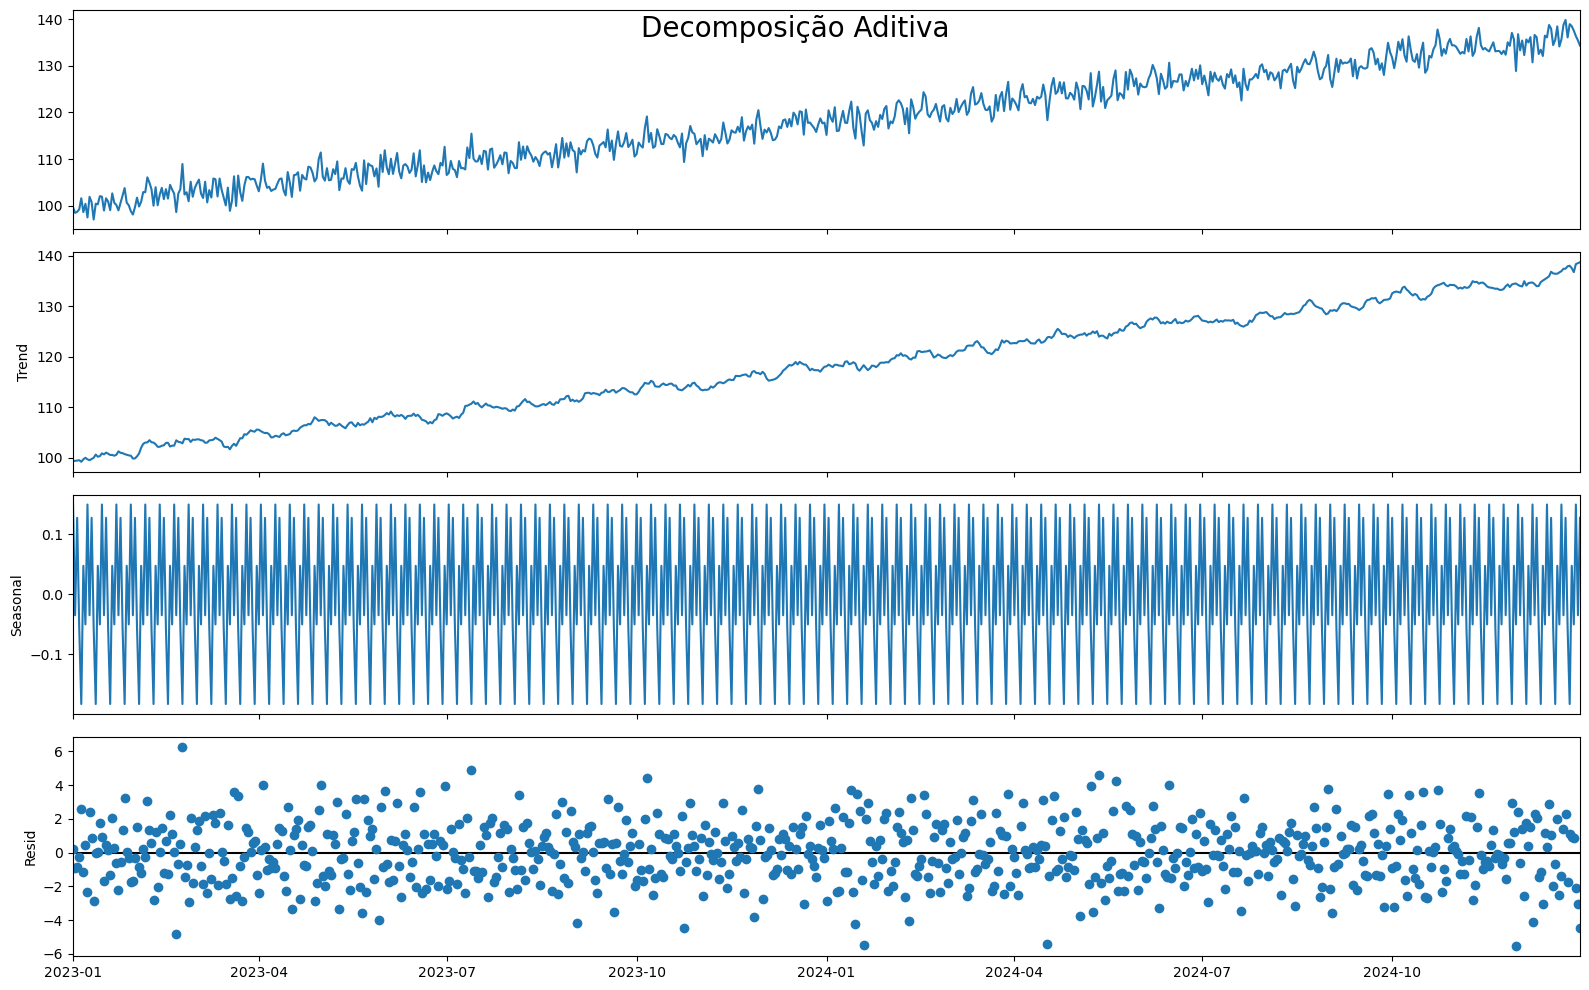

In [22]:
# Plot
plt.rcParams.update({'figure.figsize': (16,10)})
decompose_adt.plot().suptitle('Decomposição Aditiva', fontsize = 20)
plt.show()

### Análise da Decomposição:

1 - Dados observados: Demanda por Insumos Kg

2 - Tendência: a decomposição mostrou claramente linha de tendência positiva.

3 - Sazonalidade: a decomposição mostrou que existe um fator de sazonalidade com picos de aumento e queda, que pode ser explicado com eventos sazonais (calendário) na demanda.

4 - Resíduos: mostrou que na decomposição aditiva existe um padrão, e na decomposição multiplicativa a irregularidade é aleatória, o que é preferível para modelagem.

#### Extração dos Componentes da Decomposição
Regra de extração:

**Valores Reais = (sazonal * tendência * resíduo)**

In [23]:
# Concatena o resultado da decomposição da série
df_reconstruida = pd.concat([decompose_mult.seasonal, 
                                      decompose_mult.trend, 
                                      decompose_mult.resid, 
                                      decompose_mult.observed], axis = 1)

In [24]:
# Define o nome das colunas
df_reconstruida.columns = ['Sazonalidade', 'Tendência', 'Resíduos', 'Valores_Observados']

In [25]:
# Mostra o resultado
df_reconstruida.head()

,Sazonalidade,Tendência,Resíduos,Valores_Observados
data,,,,
2023-01-01,1.001191,99.366262,1.002253,99.708762
2023-01-02,0.999711,99.413079,0.990851,98.475161
2023-01-03,1.000942,99.459897,0.991570,98.714361
2023-01-04,0.999630,99.543354,0.997303,99.238156
2023-01-05,0.998686,99.228040,1.025338,101.608597


In [26]:
# 💾 Salva a decomposição em arquivos CSV
decompose_mult.trend.to_csv('dados/01-trend.csv')
decompose_mult.seasonal.to_csv('dados/02-seasonal.csv')
decompose_mult.resid.to_csv('dados/03-residual.csv')


In [27]:
type(df)

pandas.core.frame.DataFrame

### Plots da Função de Autocorrelação (ACF) e Função de Autocorrelação Parcial (PACF)

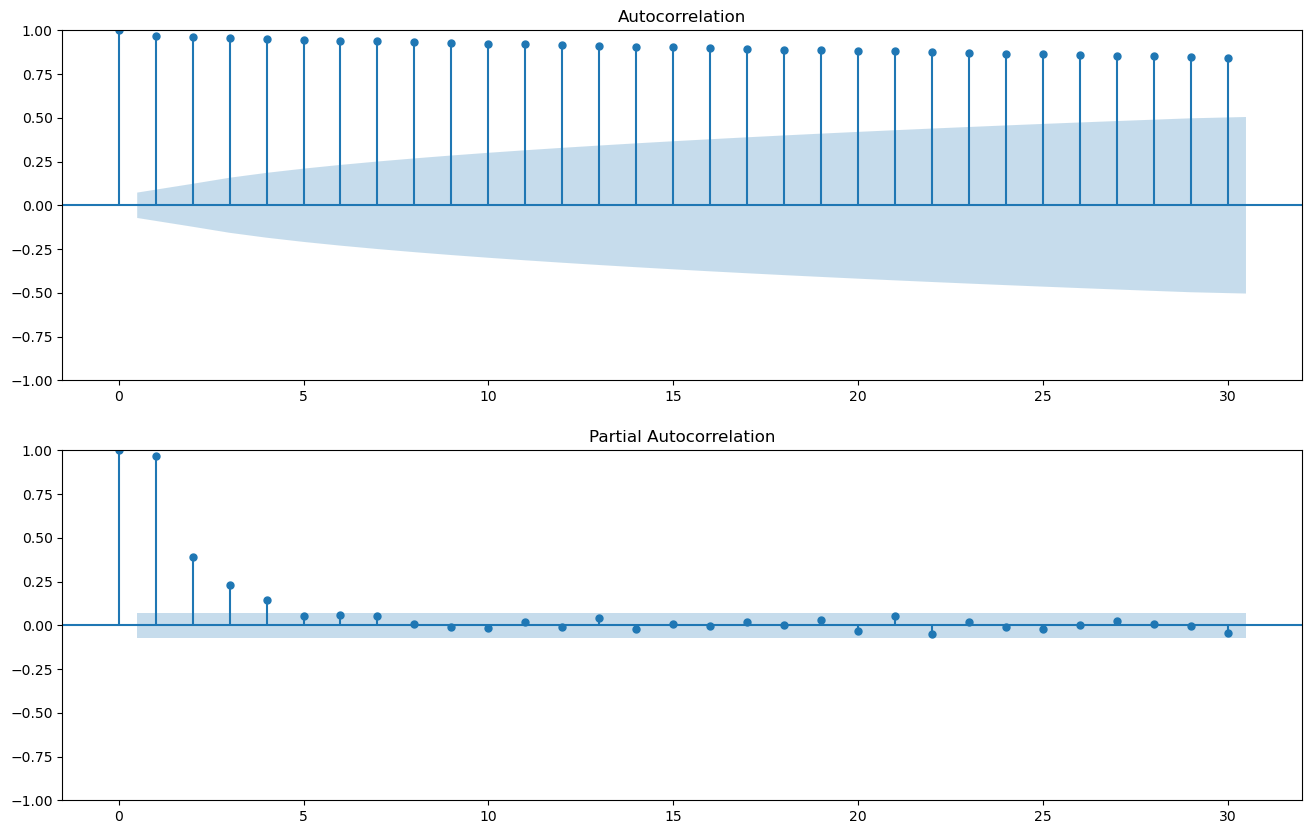

In [28]:
# Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF
plt.subplot(211)
plot_acf(df.demanda_insumos_kg, ax = plt.gca(), lags = 30)

# Plot do gráfico PACF
plt.subplot(212)
plot_pacf(df.demanda_insumos_kg, ax = plt.gca(), lags = 30, method = 'ywm')
plt.show()


Análise ACF e PACF:
 
 - Indica ...

#### Teste Estatístico Dickey Fuller

Estas são as hipóteses do teste:

- Hipótese Nula (H0): A série temporal não é estacionária.
- Hipótese Alternativa (H1): A série temporal é estacionária.

In [29]:
# Função para testar a estacionaridade (Dickey Fullher)
def testa_estacionaridade(serie, window = 12, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

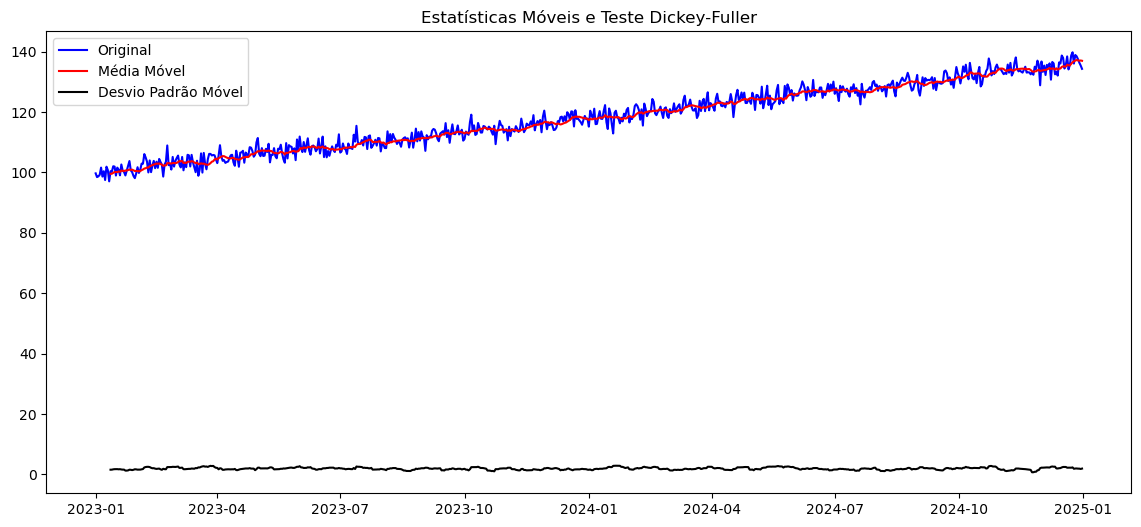


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.030946
Valor-p                           0.955897
Número de Lags Consideradas      20.000000
Número de Observações Usadas    710.000000
Valor Crítico (1%)               -3.439594
Valor Crítico (5%)               -2.865619
Valor Crítico (10%)              -2.568942
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [30]:
testa_estacionaridade(df)

Análise:

- O Valor-p é maior que 0.05. Não temos evidências estatísticas para rejeitar a hipótese nula de que a série não é estacionária. Logo, podemos concluir que a série NÃO é estacionária.

#### Transformação em Série Estacionária

In [31]:
# Aplicando Transformação Box-Cox
df['demanda_insumos_kg_Boxcox'] = boxcox(df['demanda_insumos_kg'], lmbda = 0.0)

In [32]:
df

,demanda_insumos_kg,demanda_insumos_kg_Boxcox
data,,
2023-01-01,99.708762,4.602254
2023-01-02,98.475161,4.589804
2023-01-03,98.714361,4.592230
2023-01-04,99.238156,4.597523
2023-01-05,101.608597,4.621128
...,...,...
2024-12-27,138.491737,4.930811
2024-12-28,137.528450,4.923831
2024-12-29,136.367028,4.915350


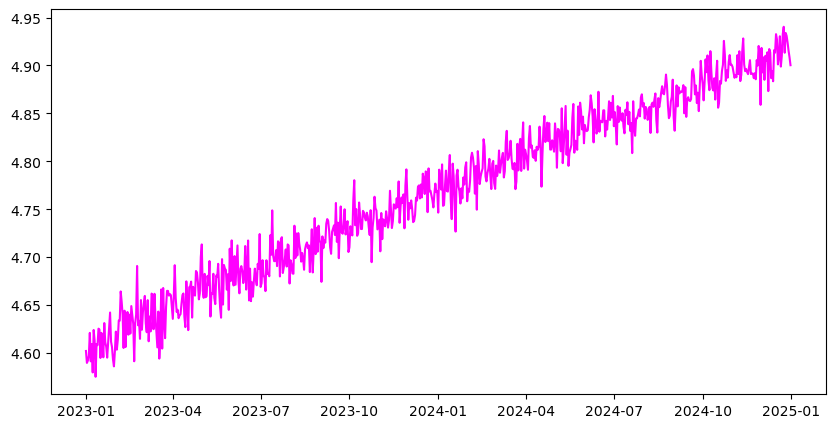

In [33]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(df['demanda_insumos_kg_Boxcox'], color = "magenta")
plt.show()

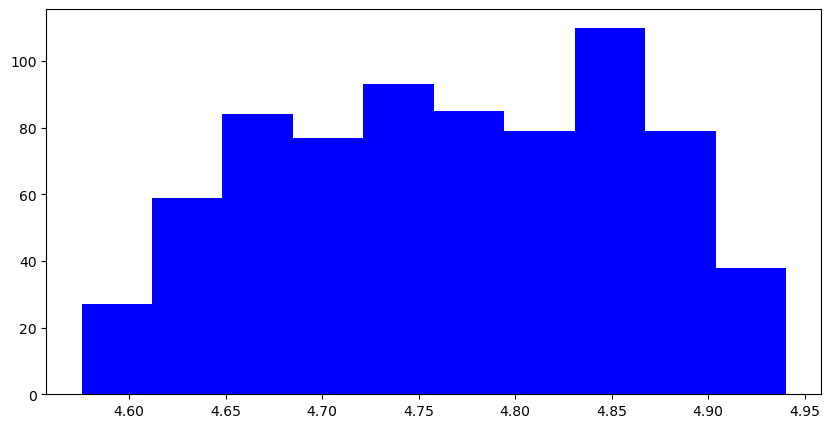

In [34]:
# Histograma
plt.figure(figsize = (10, 5))
plt.hist(df['demanda_insumos_kg_Boxcox'], color = "blue")
plt.show()

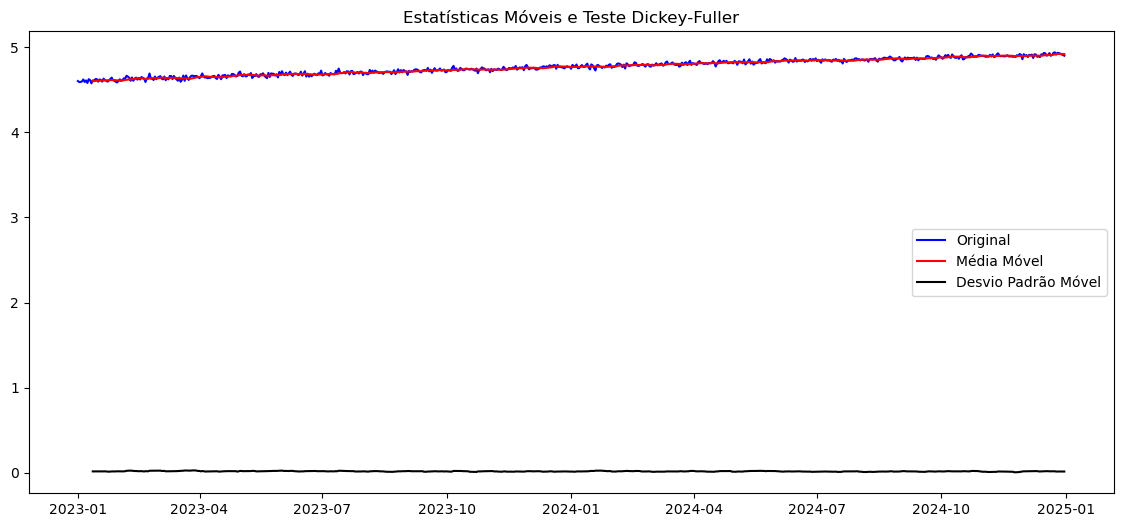


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.663866
Valor-p                           0.855889
Número de Lags Consideradas      20.000000
Número de Observações Usadas    710.000000
Valor Crítico (1%)               -3.439594
Valor Crítico (5%)               -2.865619
Valor Crítico (10%)              -2.568942
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [35]:
testa_estacionaridade(df['demanda_insumos_kg_Boxcox'])

Podemos definir o parâmetro lambda como None (o padrão) e deixar a função encontrar um valor ajustado estatisticamente.

In [36]:
# Aplicando Transformação Box-Cox
df['demanda_insumos_kg_Boxcox_2'], lam_value = boxcox(df['demanda_insumos_kg'])
print('Valor Ideal de Lambda: %f' % lam_value)
df.head()

Valor Ideal de Lambda: 0.649971


,demanda_insumos_kg,demanda_insumos_kg_Boxcox,demanda_insumos_kg_Boxcox_2
data,,,
2023-01-01,99.708762,4.602254,29.096974
2023-01-02,98.475161,4.589804,28.850084
2023-01-03,98.714361,4.592230,28.898041
2023-01-04,99.238156,4.597523,29.002915
2023-01-05,101.608597,4.621128,29.475124


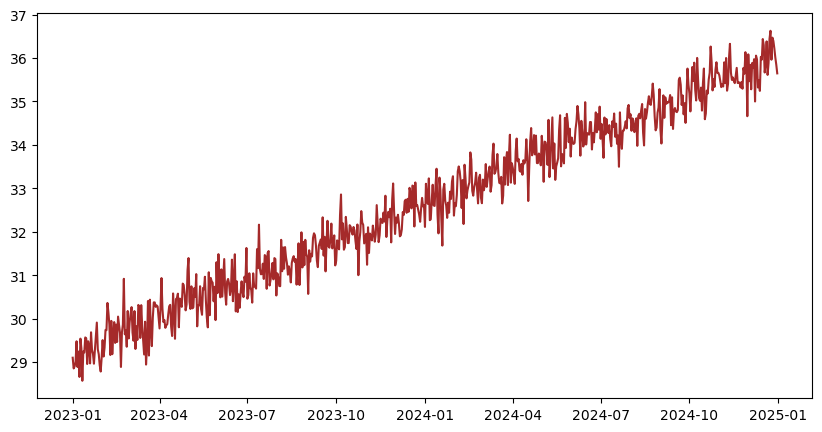

In [37]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(df['demanda_insumos_kg_Boxcox_2'], color = "brown")
plt.show()

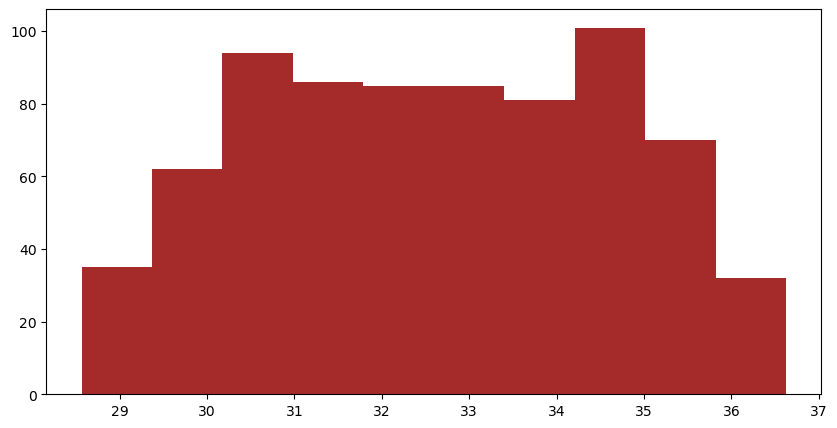

In [38]:
# Histograma
plt.figure(figsize = (10, 5))
plt.hist(df['demanda_insumos_kg_Boxcox_2'], color = "brown")
plt.show()

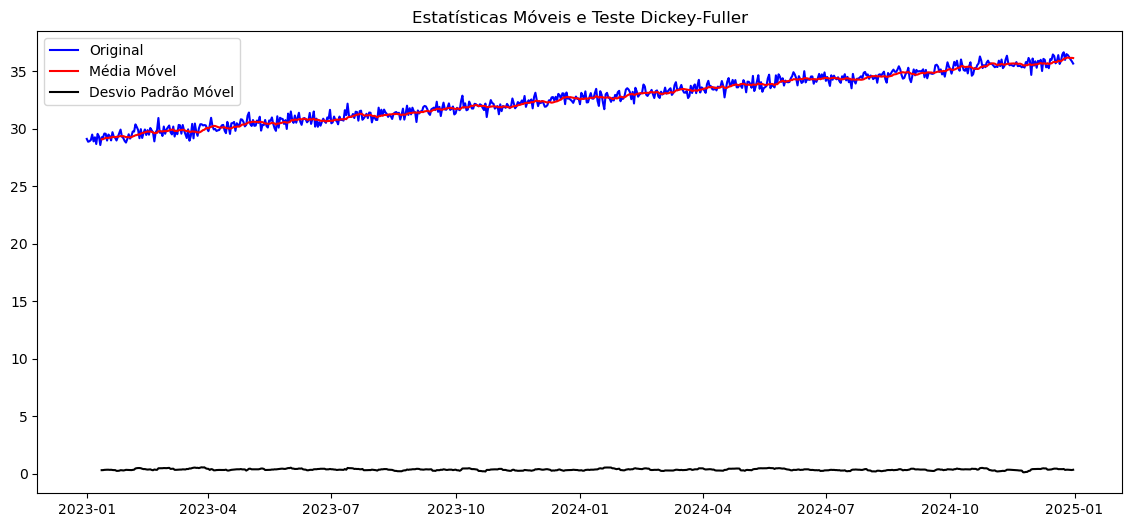


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.255121
Valor-p                           0.931624
Número de Lags Consideradas      20.000000
Número de Observações Usadas    710.000000
Valor Crítico (1%)               -3.439594
Valor Crítico (5%)               -2.865619
Valor Crítico (10%)              -2.568942
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [39]:
testa_estacionaridade(df['demanda_insumos_kg_Boxcox_2'])

In [40]:
df_series = df['demanda_insumos_kg'].copy()

In [41]:
df_series

data
2023-01-01     99.708762
2023-01-02     98.475161
2023-01-03     98.714361
2023-01-04     99.238156
2023-01-05    101.608597
                 ...    
2024-12-27    138.491737
2024-12-28    137.528450
2024-12-29    136.367028
2024-12-30    135.440340
2024-12-31    134.328530
Name: demanda_insumos_kg, Length: 731, dtype: float64

Outras Técnicas para transformar a série em estacionária.

In [42]:
#Square Root Transformation
df_sqrt = np.sqrt(df_series)

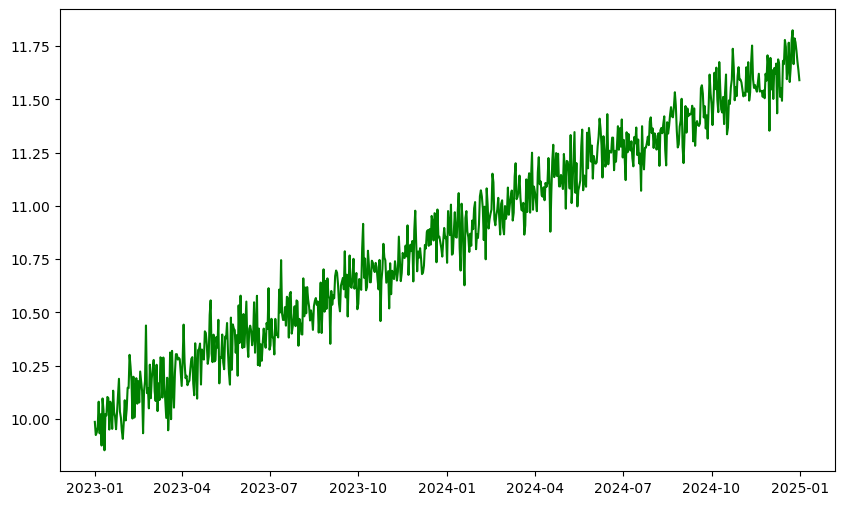

In [43]:
# Line Plot
plt.figure(figsize=(10, 6))
plt.plot(df_sqrt, color = "green")
plt.show()

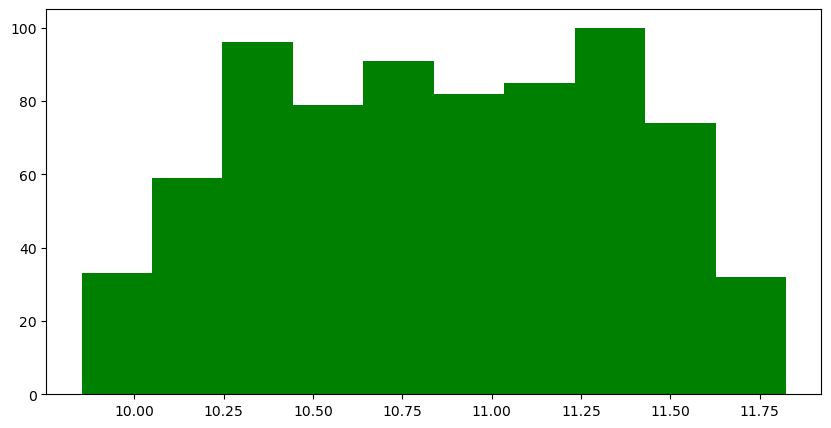

In [44]:
# Histogram
plt.figure(figsize = (10, 5))
plt.hist(df_sqrt, color = "green")
plt.show()

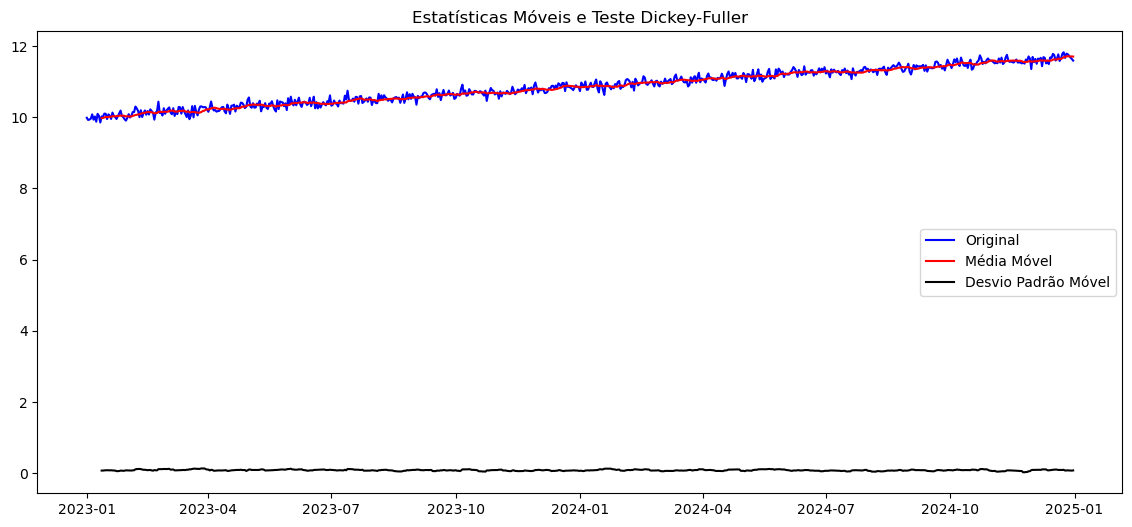


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.350445
Valor-p                           0.918050
Número de Lags Consideradas      20.000000
Número de Observações Usadas    710.000000
Valor Crítico (1%)               -3.439594
Valor Crítico (5%)               -2.865619
Valor Crítico (10%)              -2.568942
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [45]:
testa_estacionaridade(df_sqrt)

In [46]:
df_series.head()

data
2023-01-01     99.708762
2023-01-02     98.475161
2023-01-03     98.714361
2023-01-04     99.238156
2023-01-05    101.608597
Name: demanda_insumos_kg, dtype: float64

In [47]:
type(df_series)

pandas.core.series.Series

Differentiation To Remove Bias

In [48]:
# Função para diferenciação:
def diffFunc(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

In [49]:
type(df_series)

pandas.core.series.Series

In [50]:
# Colocando os dados na mesma escala
df_log = np.log(df_series)

In [51]:
df_log

data
2023-01-01    4.602254
2023-01-02    4.589804
2023-01-03    4.592230
2023-01-04    4.597523
2023-01-05    4.621128
                ...   
2024-12-27    4.930811
2024-12-28    4.923831
2024-12-29    4.915350
2024-12-30    4.908531
2024-12-31    4.900289
Name: demanda_insumos_kg, Length: 731, dtype: float64

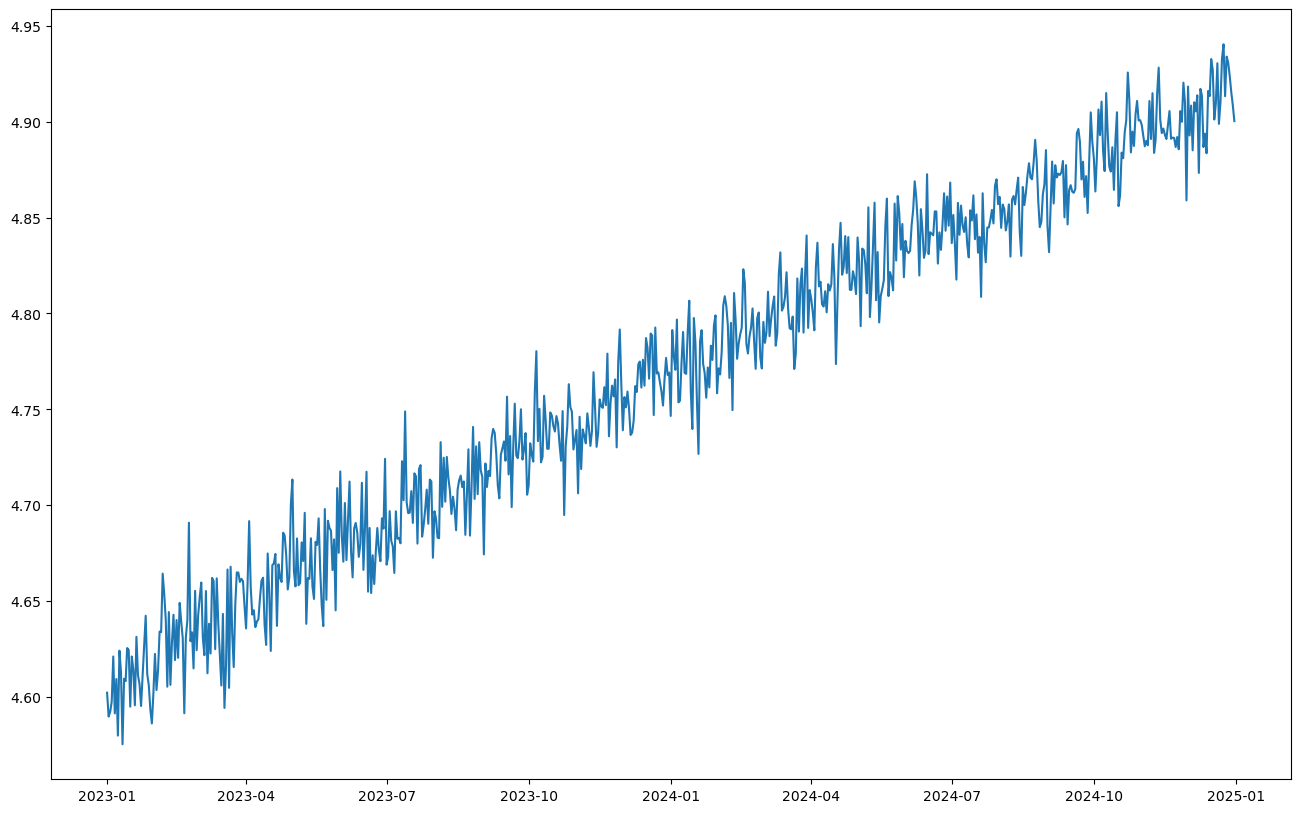

In [52]:
plt.plot(df_log)

In [53]:
#
df_serie_diff1 = df_log - df_log.shift()

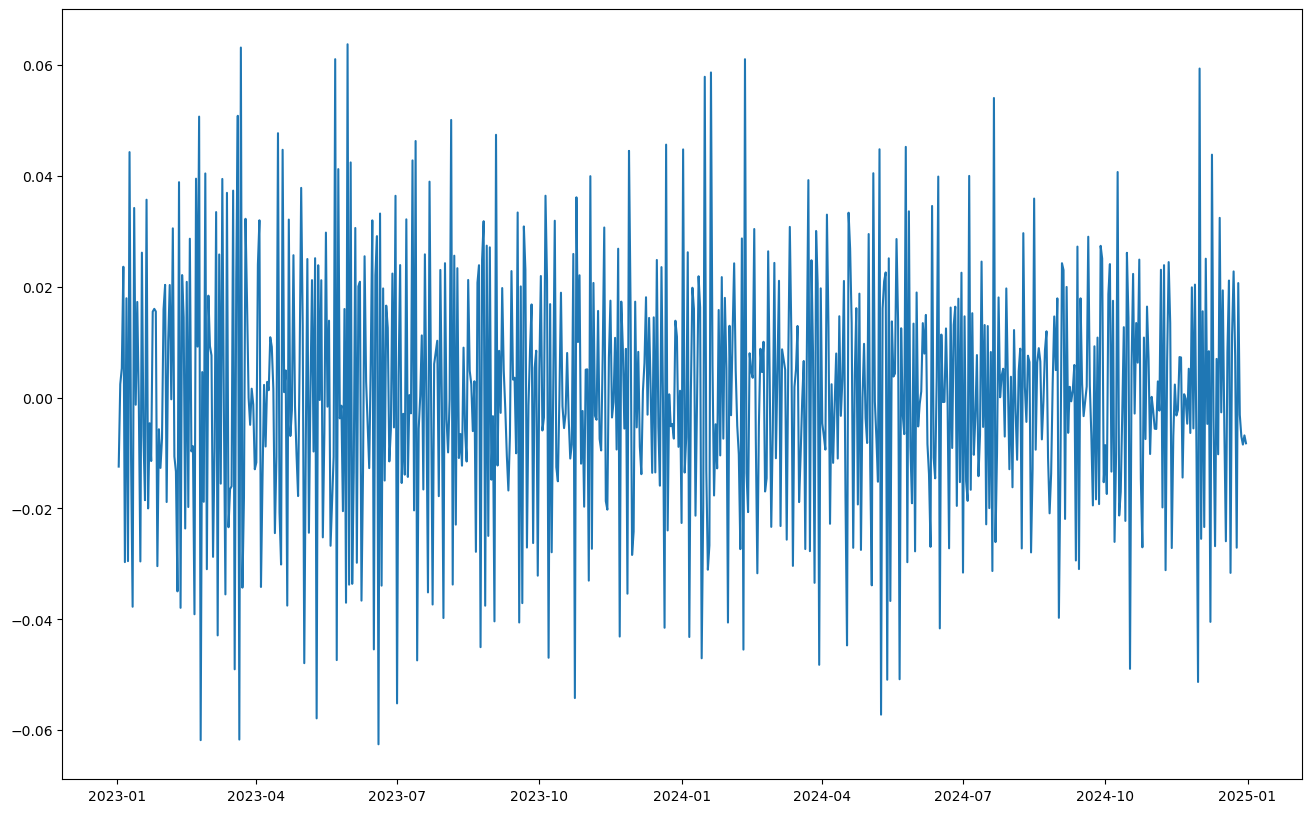

In [54]:
plt.plot(df_serie_diff1)
plt.show()

In [55]:

df_serie_diff1 = pd.DataFrame(df_serie_diff1)

In [56]:
df_serie_diff1

,demanda_insumos_kg
data,
2023-01-01,NaN
2023-01-02,-0.012449
2023-01-03,0.002426
2023-01-04,0.005292
2023-01-05,0.023606
...,...
2024-12-27,-0.003115
2024-12-28,-0.006980
2024-12-29,-0.008481


In [57]:
# Remove values NA 
df_serie_diff1.dropna(inplace = True)

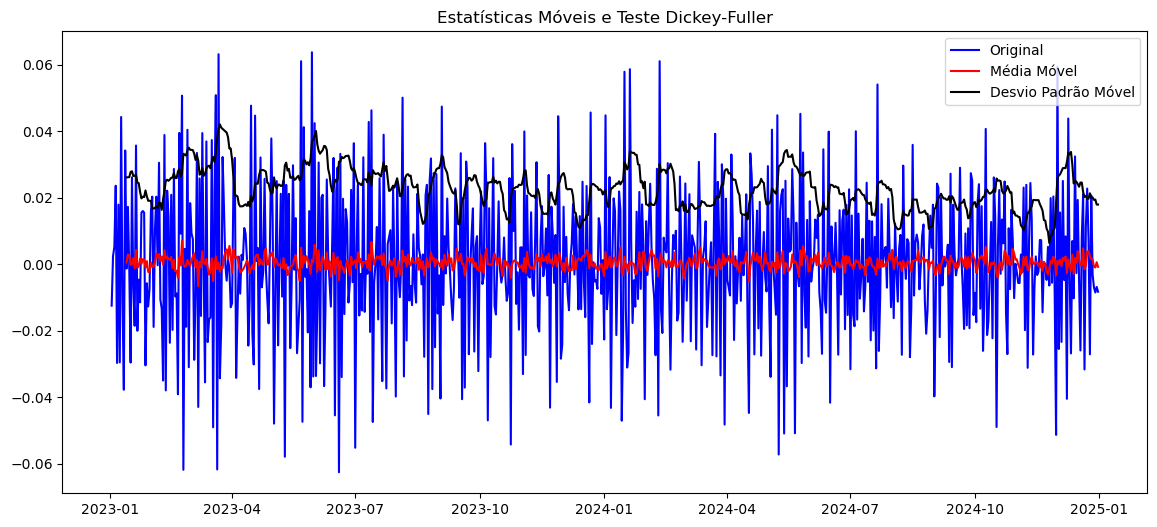


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -1.030585e+01
Valor-p                         3.280591e-18
Número de Lags Consideradas     1.900000e+01
Número de Observações Usadas    7.100000e+02
Valor Crítico (1%)             -3.439594e+00
Valor Crítico (5%)             -2.865619e+00
Valor Crítico (10%)            -2.568942e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [58]:
testa_estacionaridade(df_serie_diff1)

#### Pré-Processamento

In [63]:
df_serie_diff1

,demanda_insumos_kg
data,
2023-01-02,-0.012449
2023-01-03,0.002426
2023-01-04,0.005292
2023-01-05,0.023606
2023-01-06,-0.029678
...,...
2024-12-27,-0.003115
2024-12-28,-0.006980
2024-12-29,-0.008481


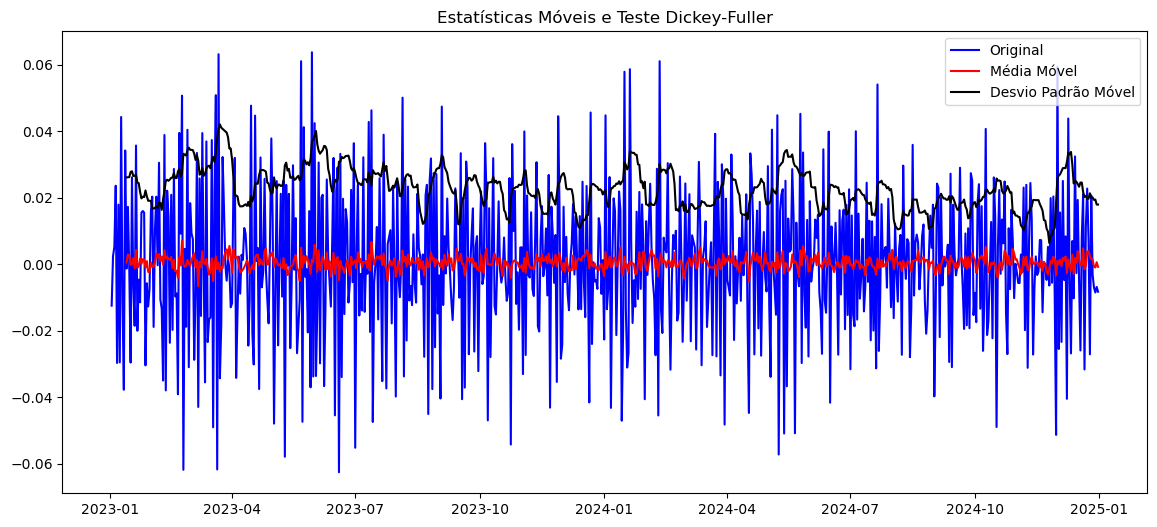


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -1.030585e+01
Valor-p                         3.280591e-18
Número de Lags Consideradas     1.900000e+01
Número de Observações Usadas    7.100000e+02
Valor Crítico (1%)             -3.439594e+00
Valor Crítico (5%)             -2.865619e+00
Valor Crítico (10%)            -2.568942e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [64]:
testa_estacionaridade(df_serie_diff1)

In [65]:
df_serie_diff1.shape

(730, 1)

In [66]:
# Divide Dados de Treino e Teste
df_treino = df_serie_diff1.iloc[0:585]
df_valid = df_serie_diff1.iloc[586:]

In [67]:
df_treino.shape

(585, 1)

In [68]:
df_valid.shape

(144, 1)

OBS: Esse dataset 'df_serie_diff1' não precisa da transformação de log (colocando os dados na mesma escala, que é requerido pelos modelos ARIMA) pois já foi trasnformado anteriormente do dataset 'df_series' copia do 'df' original.

#### Forecasting - Série Temporais

#### Modelo ARIMA

In [69]:
# Cria o Modelo ARIMA

# Definimos:

# p = 2
# d = 1
# q = 0

# Modelo
modelo_AR = ARIMA(df_treino, order = (2, 1, 0))

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [70]:
# Treinamento
modelo_v1 = modelo_AR.fit() 

In [71]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino
previsoes_v1 = modelo_v1.fittedvalues

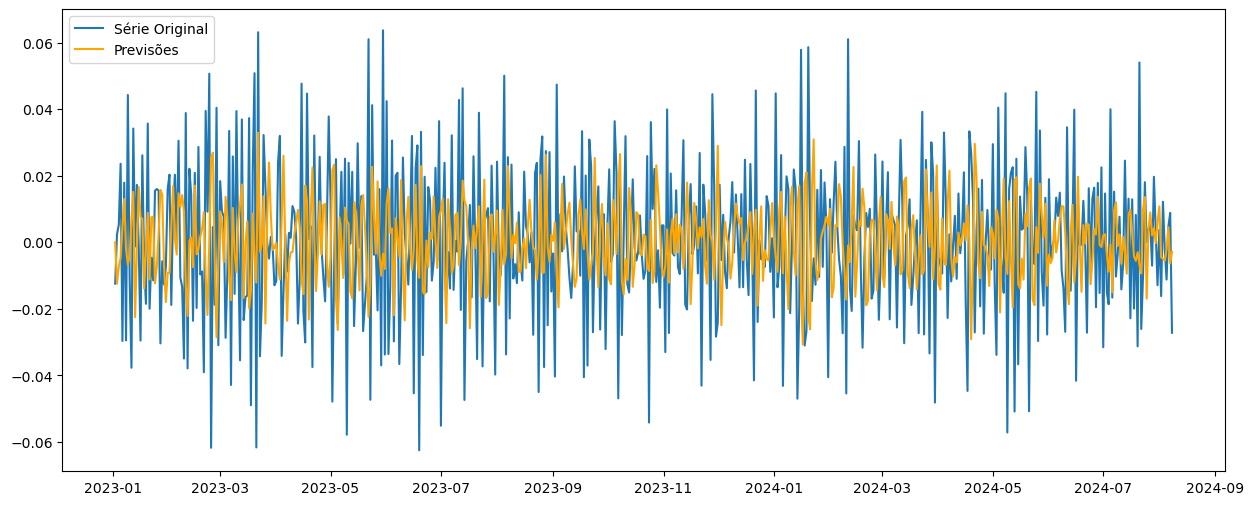

In [72]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v1, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [73]:
# Sumário do Modelo 
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     demanda_insumos_kg   No. Observations:                  585
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1287.000
Date:                seg, 07 jul 2025   AIC                          -2567.999
Time:                        16:01:40   BIC                          -2554.889
Sample:                    01-02-2023   HQIC                         -2562.890
                         - 08-08-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9693      0.038    -25.379      0.000      -1.044      -0.894
ar.L2         -0.4886      0.035    -13.846      0.000      -0.558      -0.419
sigma2         0.0007   4.17e-05     17.062      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  25.15   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.00   Prob(JB):                         1.00
Heteroskedasticity (H):               0.64   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Aqui está uma interpretação dos resultados:

Modelo: ARIMA(2,1,0) indica que o modelo é um processo autorregressivo de segunda ordem (AR(2)) com uma diferenciação (I(1)) e sem parte de médias móveis (MA(0)).

Parâmetros AR:

- ar.L1: O coeficiente do primeiro termo autorregressivo é -0.9693, o que significa que há uma relação negativa entre o valor atual da série e o valor imediatamente anterior.
- ar.L2: O coeficiente do segundo termo autorregressivo é -0.4886, indicando uma relação negativa mais fraca com o segundo valor anterior.
- Variância do erro (sigma2): O valor de 0.0007 indica a variância dos erros do modelo. Quanto menor esse valor, melhor o ajuste do modelo aos dados.

Testes Estatísticos:

- Ljung-Box (Q): O teste Ljung-Box verifica a autocorrelação residual. Um valor de p (Prob(Q)) próximo de 1, como 25.15 aqui, sugere que não há evidências significativas de autocorrelação residual, indicando um bom ajuste do modelo.
- Jarque-Bera (JB): Este teste verifica a normalidade dos resíduos. Um valor de p (Prob(JB)) próximo de 0, como aqui 0.01, indica que os resíduos não são normalmente distribuídos. Isso pode ser uma preocupação e pode valer a pena investigar mais.
- Heteroskedasticity (H): Este teste verifica a homocedasticidade dos resíduos. Um valor de p (Prob(H)) próximo de 0.64, indica que há evidências de heterocedasticidade, o que significa que a variância dos resíduos não é constante ao longo do tempo.

Medidas de ajuste:

- AIC (Akaike Information Criterion): -2567.999 Um valor menor indica um melhor ajuste do modelo, mas é usado principalmente para comparar modelos.
- BIC (Bayesian Information Criterion): -2554.889 Assim como o AIC, um valor menor indica um melhor ajuste e é usado para comparações entre modelos.
- HQIC (Hannan-Quinn Information Criterion): -2562.890 Mais uma medida para comparar modelos, com um valor menor indicando um melhor ajuste.

O modelo ARIMA(2,1,0) parece se ajustar bem aos dados em termos de autocorrelação, mas há preocupações com a normalidade e a homocedasticidade dos resíduos. Isso pode afetar as previsões do modelo e a interpretação dos intervalos de confiança. Pode ser útil investigar transformações dos dados, adicionar variáveis exógenas ou considerar modelos alternativos para melhorar o ajuste.

In [ ]:
# Transformação de log em dados de validação ????


In [74]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v1 = modelo_v1.forecast(len(df_treino), alpha = 0.05) 

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [75]:
df_previsoes_v1.shape

(585,)

In [76]:
df_previsoes_v1.head()

2024-08-09    0.005726
2024-08-10   -0.008593
2024-08-11   -0.010806
2024-08-12   -0.001665
2024-08-13   -0.009444
Freq: D, Name: predicted_mean, dtype: float64

In [77]:
# Criamos a série para o gráfico
fc_series = pd.Series(df_previsoes_v1, index = df_valid.index)

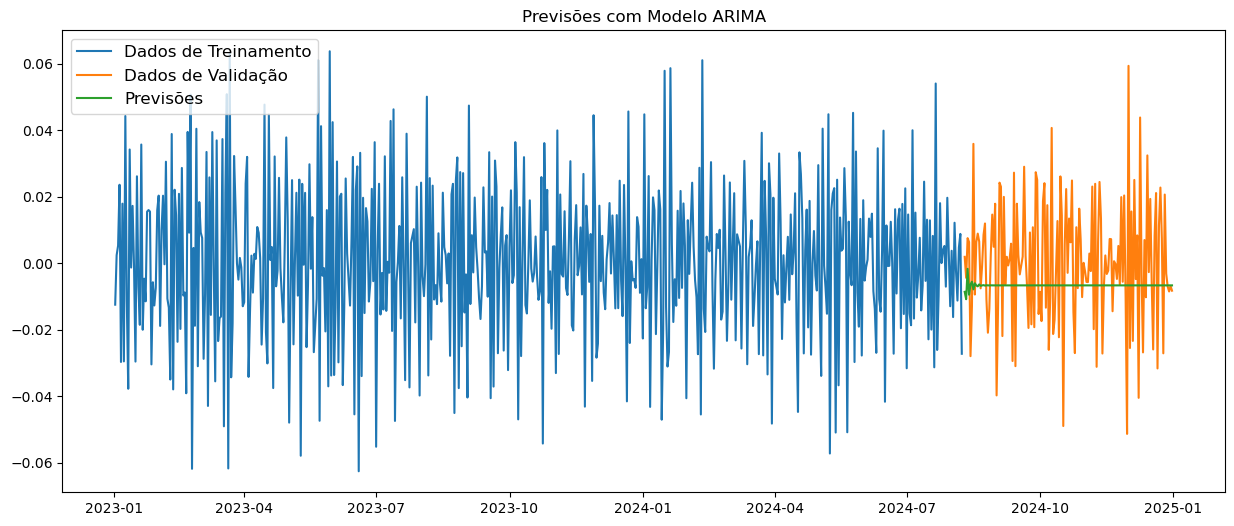

In [78]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino, label = 'Dados de Treinamento')
plt.plot(df_valid, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [79]:
# Calculando o erro do modelo
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [80]:
# Define valor real e valor previsto
y_true = df_valid
y_pred = fc_series

In [81]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.020012536138495896


O valor do RMSE baixo indica menor diferença entre as previsões e o valores reais de base do modelo.

#### Modelagem com modelo SARIMAX

In [82]:
# Cria o modelo SARIMAX
modelo_SARIMAX = SARIMAX(df_treino, trend = 'n', order = (6,1,0), seasonal_order = (0,1,1,12))

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [83]:
# Treinamento do modelo
modelo_v2 = modelo_SARIMAX.fit(disp = True)

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [84]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino
previsoes_v2 = modelo_v2.fittedvalues

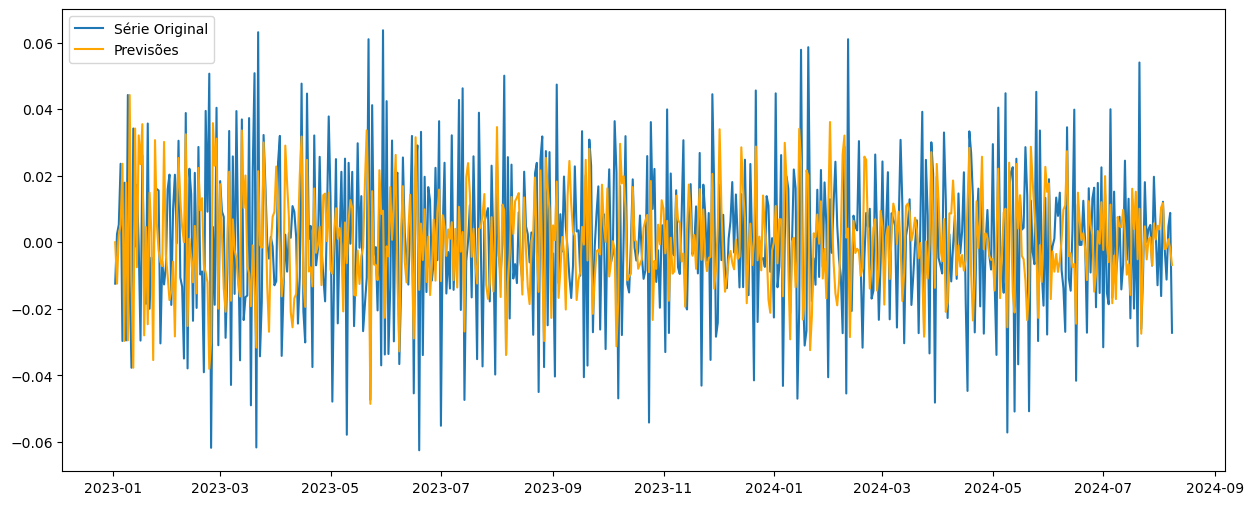

In [85]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v2, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [86]:
# Sumário do Modelo 
modelo_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                   demanda_insumos_kg   No. Observations:                  585
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 12)   Log Likelihood                1363.377
Date:                              seg, 07 jul 2025   AIC                          -2710.755
Time:                                      16:02:19   BIC                          -2675.962
Sample:                                  01-02-2023   HQIC                         -2697.182
                                       - 08-08-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4491      0.039    -37.031      0.000      -1.526      -1.372
ar.L2         -1.5199      0.065    -23.213      0.000      -1.648      -1.392
ar.L3         -1.3008      0.086    -15.192      0.000      -1.469      -1.133
ar.L4         -0.9317      0.088    -10.598      0.000      -1.104      -0.759
ar.L5         -0.5614      0.072     -7.805      0.000      -0.702      -0.420
ar.L6         -0.2179      0.043     -5.034      0.000      -0.303      -0.133
ma.S.L12      -0.9590      0.027    -36.129      0.000      -1.011      -0.907
sigma2         0.0005   2.95e-05     15.961      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):                 0.75
Prob(Q):                              0.21   Prob(JB):                         0.69
Heteroskedasticity (H):               0.78   Skew:                             0.08
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
df_previsoes_v2 = modelo_v2.forecast(len(df_valid), alpha = 0.05) 

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [88]:
df_previsoes_v2.shape

(144,)

In [89]:
# Cria a série para o gráfico
fc_series = pd.Series(df_previsoes_v2, index = df_valid.index)

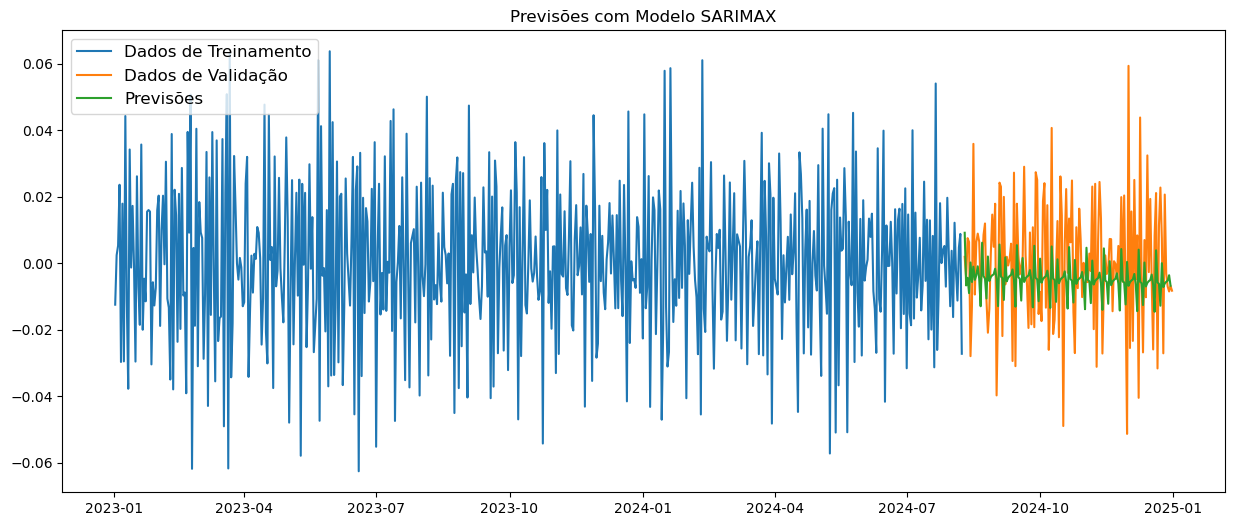

In [90]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino, label = 'Dados de Treinamento')
plt.plot(df_valid, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo SARIMAX')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [91]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [92]:
# Define valor real e valor previsto
y_true = df_valid
y_pred = fc_series

In [93]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.01948689957333089


Diminuiu ainda mais o valor do rmse, excente!

#### Previsão com Novos Dados

In [111]:
df_new_dataset = pd.read_csv('dataset_deploy.csv')

In [112]:
df_new_dataset.head()

,id,data
0,733,2025-01-01
1,734,2025-01-02
2,735,2025-01-03
3,736,2025-01-04
4,737,2025-01-05


In [114]:
df_new_dataset

,id,data
0,733,2025-01-01
1,734,2025-01-02
2,735,2025-01-03
3,736,2025-01-04
4,737,2025-01-05
5,738,2025-01-06
6,739,2025-01-07
7,740,2025-01-08
8,741,2025-01-09
9,742,2025-01-10


In [117]:
# Vamos fazer a previsão para uma janela de 30 horas
previsoes = modelo_v2.predict(start = df_new_dataset.data[0], 
                              end = df_new_dataset.data[29], 
                              dynamic = False)

In [116]:
previsoes = modelo_v2.predict(start=df_new_dataset.index[0], 
                              end=df_new_dataset.index[-1], 
                              dynamic=False)

In [119]:
print(previsoes)

2025-01-01    0.003702
2025-01-02   -0.005961
2025-01-03   -0.006369
2025-01-04   -0.012954
2025-01-05   -0.000165
2025-01-06   -0.007365
2025-01-07   -0.006266
2025-01-08   -0.005760
2025-01-09   -0.005420
2025-01-10   -0.003786
2025-01-11   -0.006946
2025-01-12   -0.014976
2025-01-13    0.003508
2025-01-14   -0.006154
2025-01-15   -0.006562
2025-01-16   -0.013147
2025-01-17   -0.000359
2025-01-18   -0.007559
2025-01-19   -0.006460
2025-01-20   -0.005953
2025-01-21   -0.005614
2025-01-22   -0.003979
2025-01-23   -0.007139
2025-01-24   -0.015169
2025-01-25    0.003315
2025-01-26   -0.006348
2025-01-27   -0.006756
2025-01-28   -0.013341
2025-01-29   -0.000552
2025-01-30   -0.007752
Freq: D, Name: predicted_mean, dtype: float64


In [121]:
# Reconstrução da série
ultimo_valor_conhecido = 134.32852977709283

In [122]:
previsoes_cumsum = np.cumsum(previsoes)

In [123]:
# Reconstituindo a série
previsoes_escala_original = ultimo_valor_conhecido + previsoes_cumsum

In [124]:
print(previsoes_escala_original)

2025-01-01    134.332231
2025-01-02    134.326271
2025-01-03    134.319902
2025-01-04    134.306948
2025-01-05    134.306783
2025-01-06    134.299417
2025-01-07    134.293151
2025-01-08    134.287391
2025-01-09    134.281971
2025-01-10    134.278185
2025-01-11    134.271239
2025-01-12    134.256264
2025-01-13    134.259772
2025-01-14    134.253618
2025-01-15    134.247055
2025-01-16    134.233908
2025-01-17    134.233549
2025-01-18    134.225990
2025-01-19    134.219531
2025-01-20    134.213577
2025-01-21    134.207963
2025-01-22    134.203984
2025-01-23    134.196845
2025-01-24    134.181676
2025-01-25    134.184991
2025-01-26    134.178643
2025-01-27    134.171887
2025-01-28    134.158547
2025-01-29    134.157994
2025-01-30    134.150242
Freq: D, Name: predicted_mean, dtype: float64


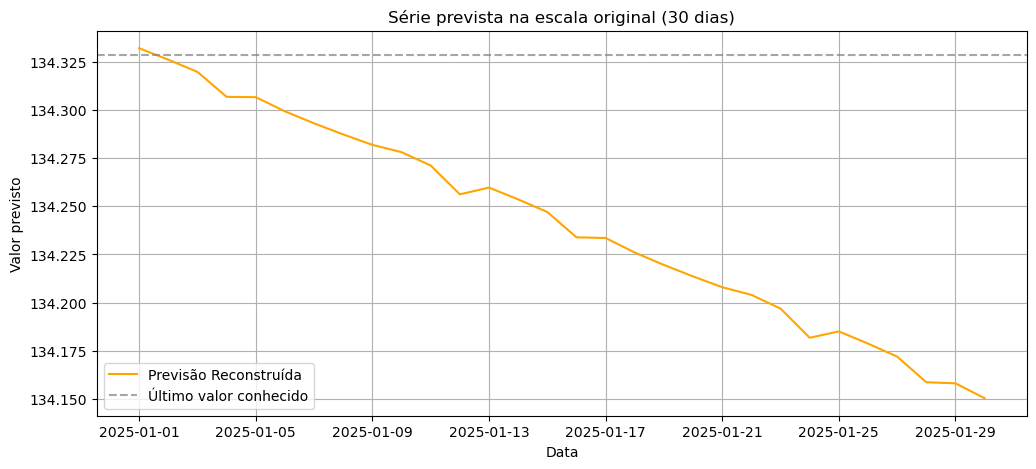

In [135]:
plt.figure(figsize=(12,5))
plt.plot(previsoes_escala_original.index, previsoes_escala_original.values, 
         color='orange', label='Previsão Reconstruída')
plt.axhline(ultimo_valor_conhecido, color='gray', linestyle='--', alpha=0.7, 
            label='Último valor conhecido')
plt.title("Série prevista na escala original (30 dias)")
plt.ylabel("Valor previsto")
plt.xlabel("Data")
plt.legend()
plt.grid(True)
plt.show()